<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Logs_dictionary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the logs dictionary

In this reading, we will learn how to take advantage of the `logs` dictionary in Keras to define our own callbacks and check the progress of a model.

The `logs` dictionary stores the loss value, along with all of the metrics we are using at the end of a batch or epoch.

We can incorporate information from the `logs` dictionary into our own custom callbacks.

Let's see this in action in the context of a model we will construct and fit to the `sklearn` diabetes dataset that we have been using in this module.

Let's first import the dataset, and split it into the training and test sets.

In [1]:
#### Package imports ####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)
        
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import get_value, set_value

2.3.0


In [2]:
# Load the diabetes dataset
diabetes_dataset = load_diabetes()
# Save the input and target variables
data = diabetes_dataset['data']
target = diabetes_dataset['target']
# Split the data set into training and test sets
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.1)

We plot training and validation loss and accuracy to observe how the accuracy of our model improves over time.

In [3]:
# Plot the learning curves
def plot_history(history):
    frame = pd.DataFrame(history.history)
    epochs = np.arange(len(frame))
    fig = plt.figure(figsize=(12,4))
    # Loss plot
    ax = fig.add_subplot(121)
    ax.plot(epochs, frame['loss'], label='Train')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss vs Epochs')
    ax.legend()
    # Accuracy plot
    ax = fig.add_subplot(122)
    ax.plot(epochs, frame['mae'], label='Train')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_title('Mean Absolute Error vs Epochs')
    ax.legend()
    plt.show()

Now we construct our model.

In [4]:
# Build the model
def get_model():
    model = Sequential([
        Dense(128, activation='relu', 
            input_shape=(train_data.shape[1],)),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)])
    return model

# Print the model summary
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 18,305
Trainable params: 18,177
Non-trainable params: 128
__________________________________________________

We now compile the model, with
* Mean squared error as the loss function,
* the Adam optimizer, and
* Mean absolute error (`mae`) as a metric.

In [5]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae'])

### Defining a custom callback

Now we define our custom callback using the `logs` dictionary to access the loss and metric values.

In [6]:
# Create the custom callback
class LossAndMetricCallback(Callback):
    # Print the loss after every second batch in the training set
    def on_train_batch_end(self, batch, logs=None):
        if batch%2==0:
            print('\n After batch {}, the loss is {:7.2f}.'.format(
                batch, logs['loss']))
            
    # Print the loss after each batch in the test set
    def on_test_batch_end(self, batch, logs=None):
        print('\n After batch {}, the loss is {:7.2f}.'.format(
            batch, logs['loss']))
        
    # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}'.format(
            epoch, logs['loss'], logs['mae']))
        
    # Notify the user when prediction has finished on each batch
    def on_predict_batch_end(self, batch, logs=None):
        print('Finished prediction on batch {}!'.format(batch))

We now fit model to the data, and specify that we would like to use our custom callback `LossAndMetricCallback()`. We can also use our callback in the `evaluate` function...and also the predict function.


 After batch 0, the loss is 27802.02.

 After batch 2, the loss is 28415.57.
Epoch 0: Average loss is 29203.08, mean absolute error is  152.45

 After batch 0, the loss is 27125.49.

 After batch 2, the loss is 28934.99.
Epoch 1: Average loss is 29118.80, mean absolute error is  152.21

 After batch 0, the loss is 32397.21.

 After batch 2, the loss is 29248.84.
Epoch 2: Average loss is 29016.22, mean absolute error is  151.89

 After batch 0, the loss is 29020.08.

 After batch 2, the loss is 28933.79.
Epoch 3: Average loss is 28854.33, mean absolute error is  151.38

 After batch 0, the loss is 32930.10.

 After batch 2, the loss is 28487.40.
Epoch 4: Average loss is 28620.01, mean absolute error is  150.64

 After batch 0, the loss is 28309.75.

 After batch 2, the loss is 27664.19.
Epoch 5: Average loss is 28285.72, mean absolute error is  149.61

 After batch 0, the loss is 26653.40.

 After batch 2, the loss is 27796.52.
Epoch 6: Average loss is 27837.70, mean absolute error is 

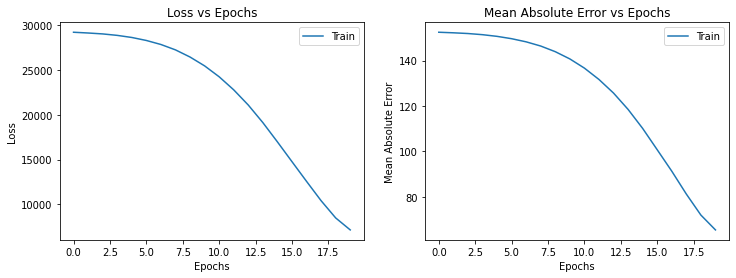


 After batch 0, the loss is 24689.61.

 After batch 1, the loss is 18628.94.

 After batch 2, the loss is 16518.65.

 After batch 3, the loss is 19015.20.

 After batch 4, the loss is 19722.42.
[19722.416015625, 121.95606231689453] 

Finished prediction on batch 0!
Finished prediction on batch 1!
Finished prediction on batch 2!
Finished prediction on batch 3!
Finished prediction on batch 4!
[[52.388405]
 [22.954905]
 [12.544161]
 [50.5256  ]
 [21.908512]
 [30.217337]
 [20.31851 ]
 [24.20364 ]
 [13.273981]
 [19.940912]
 [42.329834]
 [20.620487]
 [17.177341]
 [20.961508]
 [19.338877]
 [23.840729]
 [13.387592]
 [33.922974]
 [19.473782]
 [13.597789]
 [26.001852]
 [18.222637]
 [45.514805]
 [12.033669]
 [16.997921]
 [55.974236]
 [13.767186]
 [21.043037]
 [51.697094]
 [23.440498]
 [15.870481]
 [46.0253  ]
 [34.79394 ]
 [18.120943]
 [40.07299 ]
 [23.496777]
 [19.026443]
 [14.02095 ]
 [55.65161 ]
 [49.69997 ]
 [21.581846]
 [45.115967]
 [12.377827]
 [16.74456 ]
 [54.75807 ]]


In [7]:
# Train the model
history = model.fit(train_data, train_target, epochs=20, 
    batch_size=100, callbacks=[LossAndMetricCallback()], verbose=False)
# Plot the history
plot_history(history)

# Evaluate the model
model_eval = model.evaluate(test_data, test_target, batch_size=10,
    callbacks=[LossAndMetricCallback()], verbose=False)
print(model_eval,'\n')

# Get predictions from the model
model_pred = model.predict(test_data, batch_size=10,
    callbacks=[LossAndMetricCallback()], verbose=False)
print(model_pred)

### Application - learning rate scheduler
Let's now look at a more sophisticated custom callback.

We are going to define a callback to change the learning rate of the optimiser of a model during training. We will do this by specifying the epochs and new learning rates where we would like it to be changed.

First we define the auxillary function that returns the learning rate for each epoch based on our schedule.

In [8]:
# Define the learning rate schedule. The tuples below are 
# (start_epoch, new_learning_rate)
lr_schedule = [(4, 0.03), (7, 0.02), (11, 0.005), (15, 0.007)]

def get_new_epoch_lr(epoch, lr):
    # Checks to see if the input epoch is listed in the learning rate
    # schedule and if so, returns index in lr_schedule
    epoch_in_sched = [i for i in range(len(lr_schedule)) 
        if lr_schedule[i][0]==int(epoch)]
    if len(epoch_in_sched)>0:
        # If it is, return the learning rate corresponding to the epoch
        return lr_schedule[epoch_in_sched[0]][1]
    else:
        # Otherwise, return the existing learning rate
        return lr

Let's now define the callback itself.

In [9]:
# Define the custom callback
class LRScheduler(Callback):
    
    def __init__(self, new_lr):
        super(LRScheduler, self).__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr
        
    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning
        # rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError("Error: Optimizer does not have a learning rate.")
            
        # Get the current learning rate
        curr_rate = float(get_value(self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)
        
        # Set the learning rate to the scheduled learning rate
        set_value(self.model.optimizer.lr, scheduled_rate)
        print("Learning rate for epoch {} is {:7.3f}".format(
            epoch, scheduled_rate))

Let's now train the model again with our new callback

Learning rate for epoch 0 is   0.001
Learning rate for epoch 1 is   0.001
Learning rate for epoch 2 is   0.001
Learning rate for epoch 3 is   0.001
Learning rate for epoch 4 is   0.030
Learning rate for epoch 5 is   0.030
Learning rate for epoch 6 is   0.030
Learning rate for epoch 7 is   0.020
Learning rate for epoch 8 is   0.020
Learning rate for epoch 9 is   0.020
Learning rate for epoch 10 is   0.020
Learning rate for epoch 11 is   0.005
Learning rate for epoch 12 is   0.005
Learning rate for epoch 13 is   0.005
Learning rate for epoch 14 is   0.005
Learning rate for epoch 15 is   0.007
Learning rate for epoch 16 is   0.007
Learning rate for epoch 17 is   0.007
Learning rate for epoch 18 is   0.007
Learning rate for epoch 19 is   0.007


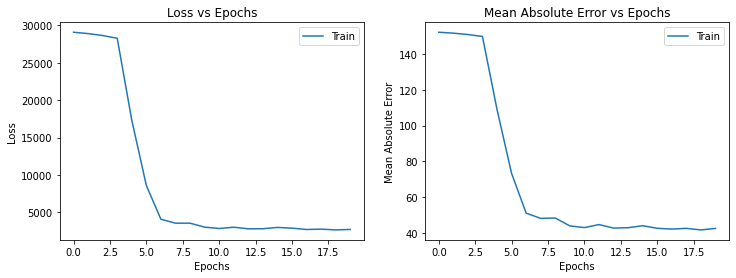

In [10]:
# Build the same model as before
new_model = Sequential([
    Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)])

# Compile the model
new_model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

# Fit the model with our learning rate scheduler callback
new_history = new_model.fit(train_data, train_target, epochs=20,
    batch_size=100, callbacks=[LRScheduler(get_new_epoch_lr)],
    verbose=False)
# Plot the history
plot_history(new_history)

### Further reading and resources
* https://www.tensorflow.org/guide/keras/custom_callback
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback